In [1]:
import databento as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import os
from pathlib import Path


from src.model.model import BasicXGBOOST1
from src.model.dataset import Dataset1


In [2]:
API_KEY = os.environ['DATABENTO_KEY']
DATASET = 'XNAS.ITCH'  # NASDAQ ITCH data or other supported dataset
SYMBOL = 'AAPL'  # Change this to your desired stock symbol
START_DATE = '2018-05-01'  # Change to the earliest date allowed by your subscription
END_DATE = '2025-02-28'  # Or the most recent date


In [3]:
client = db.Historical(API_KEY)

In [4]:
print(client.metadata.list_datasets())

['ARCX.PILLAR', 'DBEQ.BASIC', 'EPRL.DOM', 'EQUS.MINI', 'EQUS.SUMMARY', 'GLBX.MDP3', 'IEXG.TOPS', 'IFEU.IMPACT', 'MEMX.MEMOIR', 'NDEX.IMPACT', 'OPRA.PILLAR', 'XASE.PILLAR', 'XBOS.ITCH', 'XCHI.PILLAR', 'XCIS.TRADESBBO', 'XNAS.BASIC', 'XNAS.ITCH', 'XNYS.PILLAR', 'XPSX.ITCH']


In [5]:

# Jupyter notebook runs in the current working directory
current_folder = Path.cwd()
print(current_folder)
subfolder = current_folder / "data"
print(subfolder)
history_file = subfolder / "AAPL_minute_data.csv"
got_ticker = False

if history_file.exists():
    print("File exists!")
    got_ticker = True
else:
    print("File does not exist.")


/Users/carloteufel/Documents/Projects/FeatureEngineering
/Users/carloteufel/Documents/Projects/FeatureEngineering/data
File exists!


In [6]:
if got_ticker:
    print("Reading file...")
    df = pd.read_csv(history_file)
else:
    print("Fetching data...")
    # Fetch minute-bar data
    df = client.timeseries.get_range(
        dataset=DATASET,
        symbols=SYMBOL,
        schema='ohlcv-1m',
        start=START_DATE,
        end=END_DATE,
    ).to_df()

    # Display the dat
    # Optionally, save data to a CSV file
    df.to_csv(f'data/{SYMBOL}_minute_data.csv')

print('Columns:',df.columns)
print('Length:',len(df))

Reading file...
Columns: Index(['ts_event', 'rtype', 'publisher_id', 'instrument_id', 'open', 'high',
       'low', 'close', 'volume', 'symbol'],
      dtype='object')
Length: 1312278


In [7]:
df_test = df.copy()
df_test = df_test.drop(['rtype', 'publisher_id', 'instrument_id', 'symbol' ], axis=1)


In [8]:
from src.features.featurizer import Featurizer1

featurizer = Featurizer1()
df_test = featurizer.featurize(df_test)


In [9]:
df_test = df_test.drop(['ts_event'], axis=1)
len_sequence = 100
predict_horizon = 10
n_samples = 80000
n_features = df_test.shape[1]


model = BasicXGBOOST1()
dataset = Dataset1( df_test, 
                    n_samples=n_samples,
                    len_sequence=len_sequence,
                    predict_horizon=10,
                    )
dataset.process()
X_train, X_test, y_train, y_test = dataset.get_data()

Data shape: (1312278, 5)
X shape: (11716, 100, 5)
y shape: (11716,)
aux_data shape: (11716, 1)
complete_sequence shape: (11716, 110, 5)
random_start_points 11716 
 [      0     111     223 ... 1311844 1311956 1312068]


11716it [00:02, 5857.95it/s]


In [10]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.4573


True 2.0 Predicted 1


/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)
/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


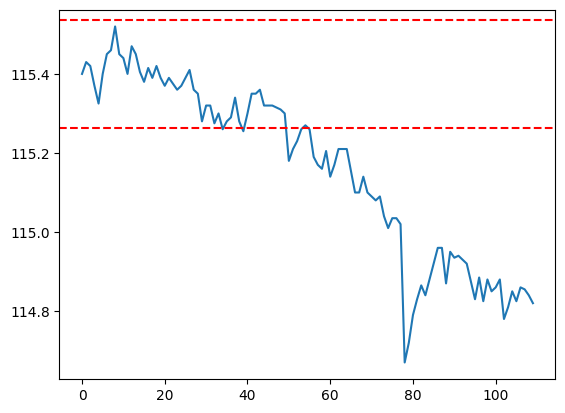

In [11]:
from src.model.utils import visualize_performance

aux_train, aux_test, complete_sequence_train, complete_sequence_test = dataset.get_aux_data()

index = 2

print('True', y_test[index], 'Predicted', y_pred[index])
visualize_performance(X_test, y_test, y_pred, index, aux_test, complete_sequence_test)



In [ ]:
from src.model.live_test import LiveStreamPredictor

pretrained_model = model  # Replace with your pre-trained model instance

predictor = LiveStreamPredictor(
    model=pretrained_model,
    symbol="AAPL",
    seq_length=10,
    api_key="",  # Your API key here
    secret_key="",  # Leave secret_key empty if not required
)

predictor.run()

Detected running event loop. Scheduling start_stream as a task.


Subscribed to live bars for AAPL.
